In [1]:
# try numpyro for MCMC

# plotting + data handling
import matplotlib.pyplot as plt
import pandas as pd
import corner

# numpy 
import numpy as np

# jax for automatic differentiation
import jax
import jax.numpy as jnp
key = jax.random.key(1234)

# numpyro for HMC
import numpyro

In [2]:
# Data

# import data from file
file = "code\1-Fragment_C_Hole_Measurements.csv"

df = pd.read_csv(file)

# just extract ID, X,Y values
data_col = df[["Section ID", "Mean(X)", "Mean(Y)"]]

jax_array = jnp.array(data_col)

# First index for ID, second index for X (1) or Y (2)
X = jax_array[:,1]
Y = jax_array[:,2]

data = [X,Y]


In [3]:
key, subkey = jax.random.split(key)

# model - takes parameters as input & calculates (xi, yi) positions on circle

# R radius of mechanism
# N npoints for whole mechanism
# sigma_r radial error
# sigma_t tangential error - for isotropic model set sigma_r = sigma_t = sigma (uniform x,y error)
# xc central position of x coordinate for each section (x8)
# yc central position of y coordinate for each section (x8)
# a alpha phase shift of each section (x8)

sizes = [1,22,9,37,1,3,2,6] # no. points in each section

# explicitly require separate parameters for xc0,xc1,xc2 etc...

def modelxy(N,R,a0,a1,a2,a3,a4,a5,a6,a7,xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7):
    
    xc = [xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7]
    yc = [yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7]
    a = [a0,a1,a2,a3,a4,a5,a6,a7]

    # duplicate values of xc, yc, alpha, to make array of length 81 (matching no. points) with values corresponding to each section
    # this is equivalent to iterating over [i] which doesn't work in this JAX-numpyro format

    xc_expand = jnp.array([val for val, count in zip(xc, sizes) for _ in range(count)])
    yc_expand = jnp.array([val for val, count in zip(yc, sizes) for _ in range(count)])
    a_expand = jnp.array([val for val, count in zip(a, sizes) for _ in range(count)])
    
    # index points 1-81 with i = [0,80]
    index = jnp.linspace(0,80,81)

    # phase offset for each point from start of its section
    phi = 2 * jnp.pi * index/N  +  (a_expand * jnp.pi/180) # degrees --> radians

    # model (x,y) coordinates
    xi = (R * jnp.cos(phi) + xc_expand)
    yi = (R * jnp.sin(phi) + yc_expand)
    

    return xi,yi,phi


In [36]:
# Aligned Model (radial-tangential)

def numpyro_model_aligned(X,Y):

    # priors on all parameters

    R = numpyro.sample("R", numpyro.distributions.Uniform(60, 100))
    N = numpyro.sample("N", numpyro.distributions.Uniform(340,370))

    xc0 = numpyro.sample("xc0", numpyro.distributions.Uniform(70,90))
    xc1 = numpyro.sample("xc1", numpyro.distributions.Uniform(70,90))
    xc2 = numpyro.sample("xc2", numpyro.distributions.Uniform(70,90))
    xc3 = numpyro.sample("xc3", numpyro.distributions.Uniform(70,90))
    xc4 = numpyro.sample("xc4", numpyro.distributions.Uniform(70,90))
    xc5 = numpyro.sample("xc5", numpyro.distributions.Uniform(70,90))
    xc6 = numpyro.sample("xc6", numpyro.distributions.Uniform(70,90))
    xc7 = numpyro.sample("xc7", numpyro.distributions.Uniform(70,90))

    yc0 = numpyro.sample("yc0", numpyro.distributions.Uniform(130,140))
    yc1 = numpyro.sample("yc1", numpyro.distributions.Uniform(130,140))
    yc2 = numpyro.sample("yc2", numpyro.distributions.Uniform(130,140))
    yc3 = numpyro.sample("yc3", numpyro.distributions.Uniform(130,140))
    yc4 = numpyro.sample("yc4", numpyro.distributions.Uniform(130,140))
    yc5 = numpyro.sample("yc5", numpyro.distributions.Uniform(130,140))
    yc6 = numpyro.sample("yc6", numpyro.distributions.Uniform(130,140))
    yc7 = numpyro.sample("yc7", numpyro.distributions.Uniform(130,140))

    a0 = numpyro.sample("a0", numpyro.distributions.Uniform(-150,-140))
    a1 = numpyro.sample("a1", numpyro.distributions.Uniform(-150,-140))
    a2 = numpyro.sample("a2", numpyro.distributions.Uniform(-150,-140))
    a3 = numpyro.sample("a3", numpyro.distributions.Uniform(-150,-140))
    a4 = numpyro.sample("a4", numpyro.distributions.Uniform(-150,-140))
    a5 = numpyro.sample("a5", numpyro.distributions.Uniform(-150,-140))
    a6 = numpyro.sample("a6", numpyro.distributions.Uniform(-150,-140))
    a7 = numpyro.sample("a7", numpyro.distributions.Uniform(-150,-140))

    # bundle all parameters:

    params = N,R,a0,a1,a2,a3,a4,a5,a6,a7,xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7

    # model predictions for (X,Y)

    #model = numpyro.deterministic("model", modelrt(*params))

    #Xi, Yi, phi = model

    Xi, Yi, phi = modelxy(*params)

    # Project model Xi, Yi into radial & tangential components

    r_pi = Xi * jnp.cos(phi) + Yi * jnp.sin(phi)
    t_pi = Xi * jnp.sin(phi) - Yi * jnp.cos(phi)

    r_p = X * jnp.cos(phi) + Y * jnp.sin(phi)
    t_p = X * jnp.sin(phi) - Y * jnp.cos(phi)

    # priors for radial AND tangential sigmas

    sigma_r = numpyro.sample("sigma_r", numpyro.distributions.Normal(0.25, 0.5))
    sigma_t = numpyro.sample("sigma_t", numpyro.distributions.Normal(0.25, 0.5))

    with numpyro.plate("data", X.shape[0]):

        numpyro.sample("obs_r", numpyro.distributions.Normal(r_pi, sigma_r), obs=r_p)
        numpyro.sample("obs_t", numpyro.distributions.Normal(t_pi, sigma_t), obs=t_p)



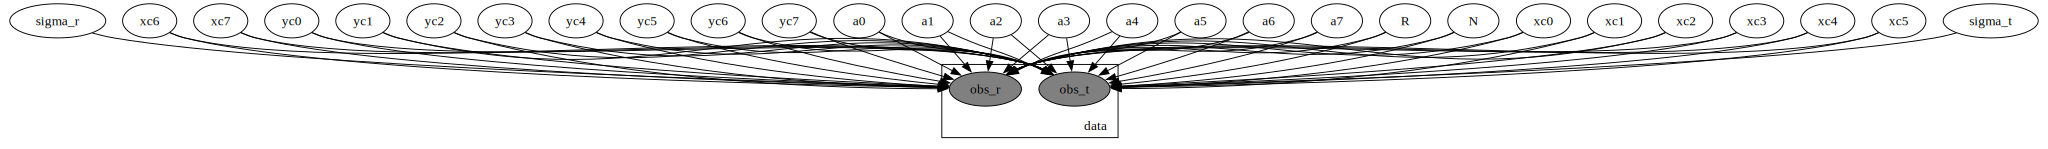

In [37]:
# visualize model
# unlike the isotropic model, xc and yc now affect BOTH obs_r and obs_t, and the sigmas are independent

numpyro.render_model(numpyro_model_aligned, model_args=(X,Y))
    

In [38]:
# Run MCMC on radial/tangential model

nuts_kernel = numpyro.infer.NUTS(numpyro_model_aligned)
mcmc_aligned = numpyro.infer.MCMC(nuts_kernel, num_warmup=100, num_samples=1000, num_chains=8)

mcmc_aligned.run(subkey, X,Y)
mcmc_aligned.print_summary()  

/tmp/ipykernel_4124673/1474417771.py:4: UserWarning: There are not enough devices to run parallel chains: expected 8 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(8)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_aligned = numpyro.infer.MCMC(nuts_kernel, num_warmup=100, num_samples=1000, num_chains=8)
sample: 100%|██████████| 1100/1100 [00:19<00:00, 56.38it/s, 1023 steps of size 4.00e-03. acc. prob=0.97]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         N    355.17      1.40    355.18    352.87    357.40   1941.06      1.00
         R     77.32      0.28     77.32     76.87     77.80   1937.76      1.00
        a0   -145.93      2.21   -145.87   -149.35   -142.41    128.48      1.08
        a1   -145.72      0.06   -145.72   -145.83   -145.62   2928.85      1.00
        a2   -145.68      0.19   -145.68   -145.99   -145.37   4053.12      1.00
        a3   -145.55      0.20   -145.55   -145.88   -145.22   1959.74      1.00
        a4   -144.94      2.92   -144.88   -149.66   -140.69    110.59      1.07
        a5   -146.71      0.90   -146.71   -148.17   -145.22   2483.69      1.01
        a6   -146.25      1.86   -146.30   -149.47   -143.31    252.68      1.03
        a7   -147.82      0.43   -147.82   -148.56   -147.16   2311.33      1.00
   sigma_r      0.03      0.00      0.03      0.02      0.03   5246.91      1.00
   sigma_t      0.13      0

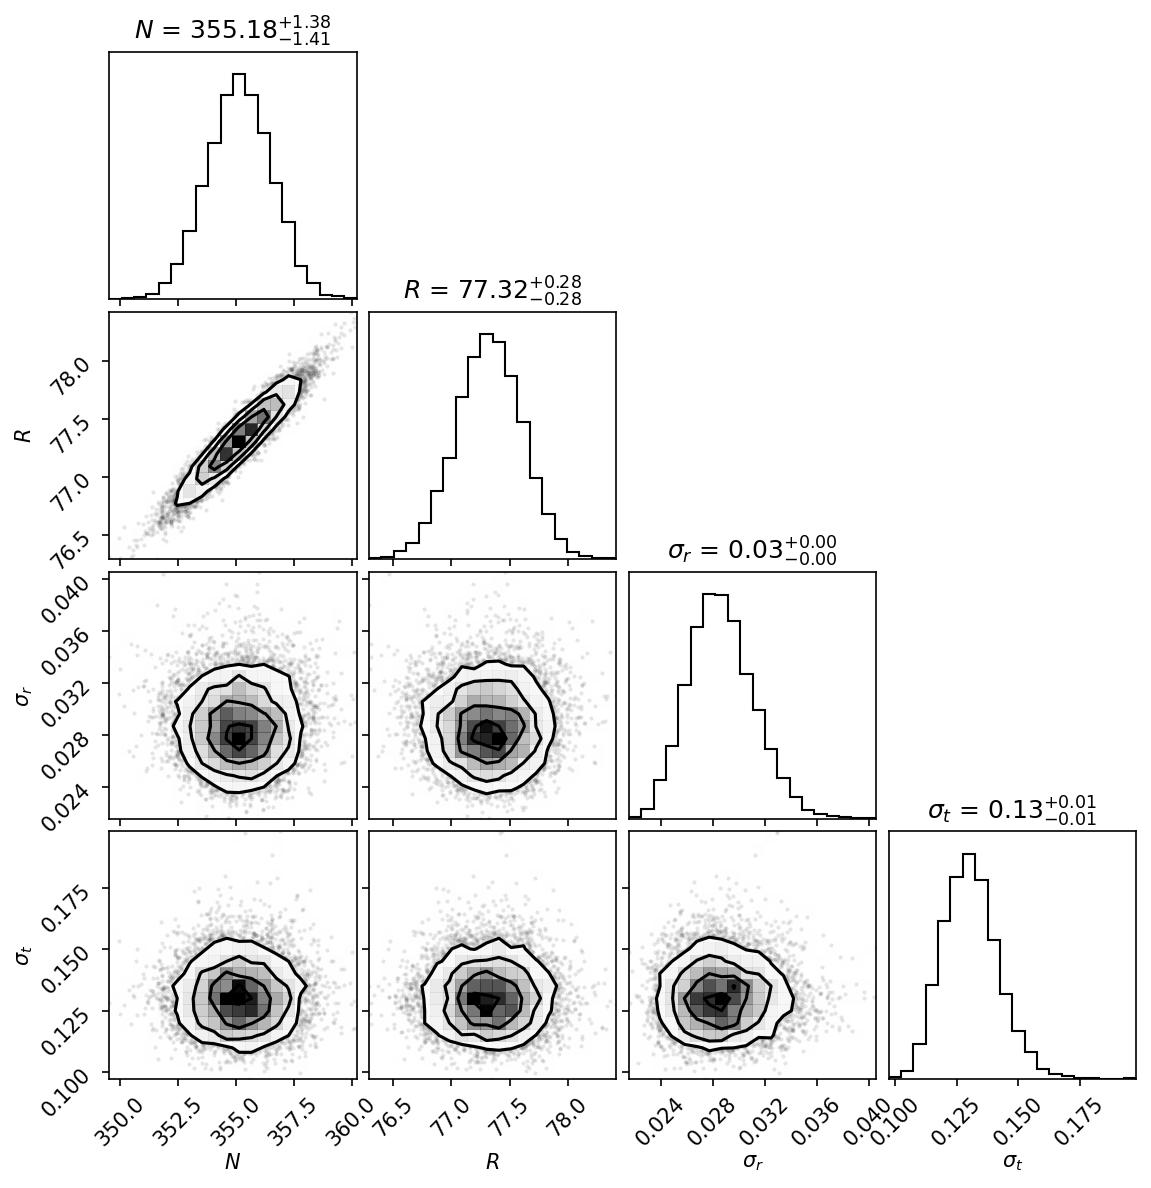

In [39]:
# corner plot

fig = plt.figure(figsize=(8, 8), dpi=150) 
samples_aligned = mcmc_aligned.get_samples()
corner.corner(np.array(jnp.vstack((samples_aligned['N'], 
                                   samples_aligned['R'],
                                   samples_aligned['sigma_r'],
                                   samples_aligned['sigma_t'])).T),
              labels=[r'$N$', r'$R$', r'$\sigma_r$',r'$\sigma_t$'],fig=fig, show_titles=True)
plt.show()

In [40]:
# obtain sampling information

import arviz as az

posterior_aligned = az.from_numpyro(mcmc_aligned)

samples_aligned = posterior_aligned.posterior 


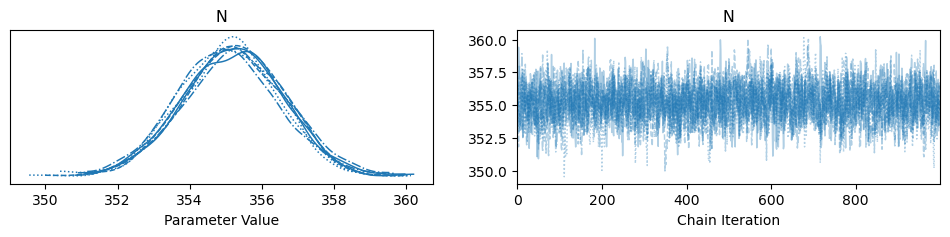

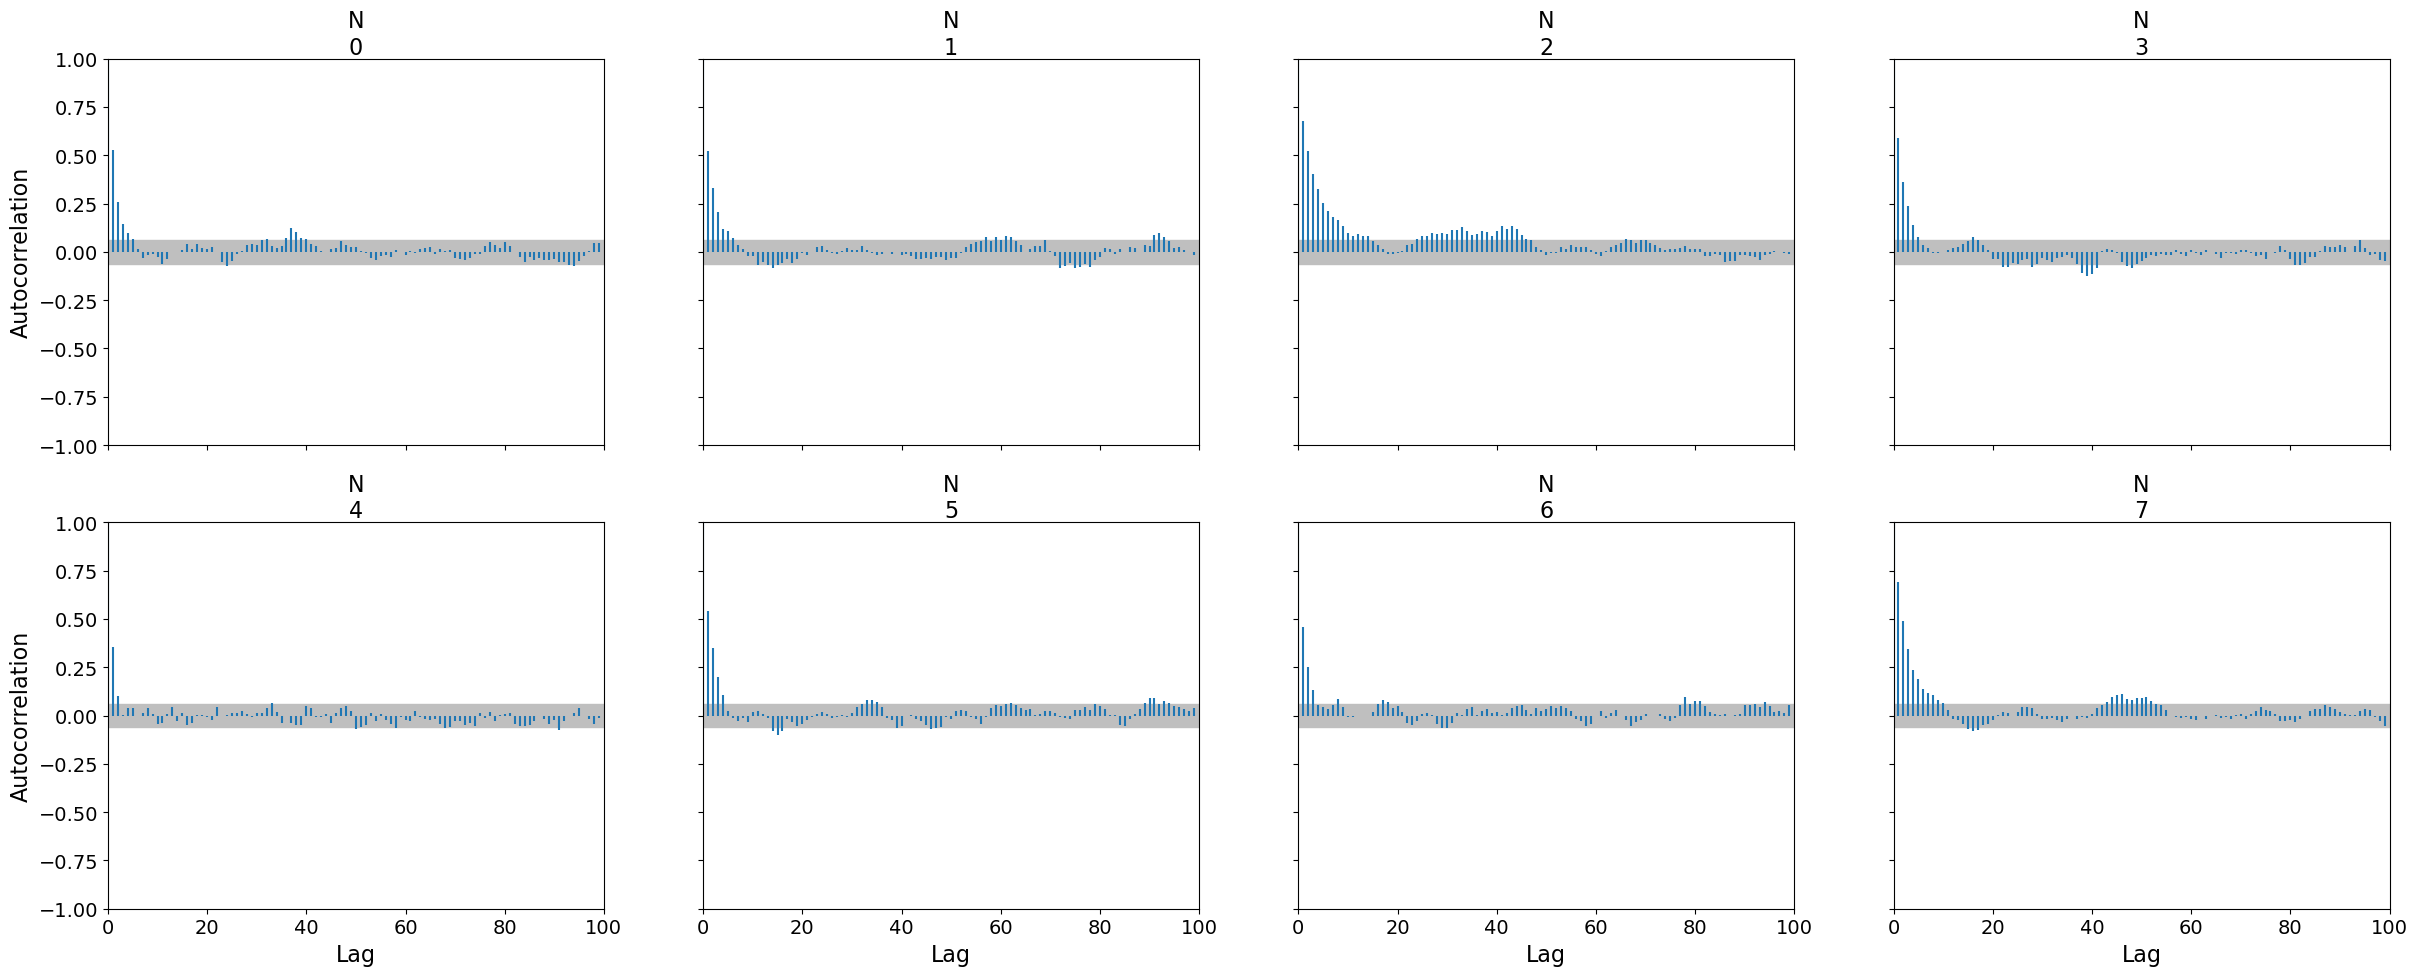

In [41]:

# Trace plot
ax = az.plot_trace(samples_aligned, var_names=['N'])

# Plot autocorrelation
ax2 = az.plot_autocorr(samples_aligned, var_names=["N"])

ax[0, 0].set_xlabel("Parameter Value")   # Left subplot (posterior distribution)
ax[0, 1].set_xlabel("Chain Iteration")   # Right subplot (trace)

ax2[1,0].set_xlabel("Lag",fontsize=16)

ax2[1,1].set_xlabel("Lag",fontsize=16)

ax2[1,2].set_xlabel("Lag",fontsize=16)

ax2[1,3].set_xlabel("Lag",fontsize=16)

ax2[0,0].set_ylabel("Autocorrelation", fontsize=16)
ax2[1,0].set_ylabel("Autocorrelation", fontsize=16)
plt.show()

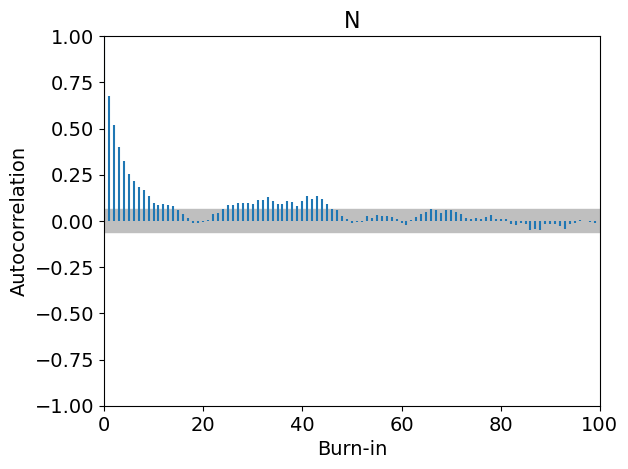

In [42]:
chain_id = 2  # Change this to select a different chain

# Extract the first chain
single_chain_samples = samples_aligned.sel(chain=chain_id)

# Plot autocorrelation for the selected chain
ax = az.plot_autocorr(single_chain_samples, var_names=["N"])
ax.set_xlabel("Burn-in",fontsize=14)
ax.set_ylabel("Autocorrelation",fontsize=14)
plt.show()

In [43]:
# make latex table with credible intervals

def format_latex_table(samples,levels=[68, 90, 95, 99]):
    latex = r"""\begin{tabular}{l c c c c c}
\textbf{parameter} & \textbf{median} & \textbf{68\%} & \textbf{90\%} & \textbf{95\%} & \textbf{99\%}\\
\hline
"""

    for param, values in samples.items():
        median = np.median(values)
        
        row = rf"{{{param}}} & {{{median:.2f}}}"

        for level in levels:
            lower = (100 - level) / 2
            upper = 100 - lower
            ci = np.percentile(values, [lower, upper])

            # Format: median ± difference
            lower_diff = median - ci[0]
            upper_diff = ci[1] - median

            row += rf" & \scriptsize{{\begin{{tabular}}{{@{{}}c@{{}}}}" \
                   rf"$+{upper_diff:.2f}$ \\" \
                   rf"$-{lower_diff:.2f}$" \
                   rf"\end{{tabular}}}}"
            
        latex += r"\vspace{4pt}" + row + r" \\" + "\n" 

    latex += r"\hline" + "\n\\end{tabular}"

    return latex

# Generate LaTeX table
latex_table = format_latex_table(samples_aligned)

# Save to file
with open("mcmc_results_table_aligned.tex", "w") as f:
    f.write(latex_table)

print("LaTeX table with vertically aligned small intervals saved to mcmc_results_table.tex")


LaTeX table with vertically aligned small intervals saved to mcmc_results_table.tex


In [44]:
# extract median & 68% error values for hole plotting

medians = []
plus_minus = []

for param, values in samples_aligned.items():
        medians.append(np.median(values))
        lower = ((100 - 68) / 2)
        upper = 100 - lower

        plus_minus.append(np.percentile(values, [lower, upper]))

In [49]:
# draw 50 samples from the posterior predictive distribution. Also plot the measured hole position
# in grey and use crosshair to show the x-y or radial-tangential errors.


num_samples = 50

# Get posterior samples from MCMC
posterior_samples = mcmc_aligned.get_samples()

# Randomly select 50 samples from posterior
indices = jax.random.choice(key, posterior_samples['N'].shape[0], (num_samples,), replace=False)
selected_samples = {k: v[indices] for k, v in posterior_samples.items()}


In [50]:
# Extract individual parameters
N = selected_samples['N']
R = selected_samples['R']
a0 = selected_samples['a0']
a1 = selected_samples['a1']
a2 = selected_samples['a2']
a3 = selected_samples['a3']
a4 = selected_samples['a4']
a5 = selected_samples['a5']
a6 = selected_samples['a6']
a7 = selected_samples['a7']
xc0 = selected_samples['xc0']
xc1 = selected_samples['xc1']
xc2 = selected_samples['xc2']
xc3 = selected_samples['xc3']
xc4 = selected_samples['xc4']
xc5 = selected_samples['xc5']
xc6 = selected_samples['xc6']
xc7 = selected_samples['xc7']
yc0 = selected_samples['yc0']
yc1 = selected_samples['yc1']
yc2 = selected_samples['yc2']
yc3 = selected_samples['yc3']
yc4 = selected_samples['yc4']
yc5 = selected_samples['yc5']
yc6 = selected_samples['yc6']
yc7 = selected_samples['yc7']

sigma_r = selected_samples['sigma_r']
sigma_t = selected_samples['sigma_t']



In [51]:

def model(R,N,xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7,a0,a1,a2,a3,a4,a5,a6,a7):
    
    xc = [xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7]
    yc = [yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7]
    a = [a0,a1,a2,a3,a4,a5,a6,a7]

    # duplicate values of xc, yc, alpha, to make array of length 81 (matching no. points) with values corresponding to each section
    # this is equivalent to iterating over [i] which doesn't work in this JAX-numpyro format

    xc_expand = jnp.array([val for val, count in zip(xc, sizes) for _ in range(count)])
    yc_expand = jnp.array([val for val, count in zip(yc, sizes) for _ in range(count)])
    a_expand = jnp.array([val for val, count in zip(a, sizes) for _ in range(count)])
    
    # index points 1-81 with i = [0,80]
    index = jnp.linspace(0,80,81)

    # phase offset for each point from start of its section
    phi = 2 * jnp.pi * index/N  +  (a_expand * jnp.pi/180) # degrees --> radians

    # model (x,y) coordinates
    xi = (R * jnp.cos(phi) + xc_expand)
    yi = (R * jnp.sin(phi) + yc_expand)
    

    return xi,yi


posteriorrt = []

for i in range(len(N)):
    posteriorrt += model(R[i], N[i], xc0[i], xc1[i], xc2[i], xc3[i], xc4[i], xc5[i], xc6[i], xc7[i], yc0[i], yc1[i], yc2[i], yc3[i], yc4[i], yc5[i], yc6[i], yc7[i], a0[i], a1[i], a2[i], a3[i], a4[i], a5[i], a6[i], a7[i])

In [ ]:
# slice the 38th hole 

hole38 = np.array([arr[37] for arr in posteriorrt])

In [53]:
medians = []
for param, values in samples_aligned.items():
        medians.append(np.median(values))


[np.float32(355.17987),
 np.float32(77.32409),
 np.float32(-145.8693),
 np.float32(-145.72342),
 np.float32(-145.67633),
 np.float32(-145.54785),
 np.float32(-144.87625),
 np.float32(-146.71133),
 np.float32(-146.29553),
 np.float32(-147.81609),
 np.float32(0.028512582),
 np.float32(0.1302617),
 np.float32(79.623215),
 np.float32(79.67909),
 np.float32(79.90056),
 np.float32(79.85814),
 np.float32(79.027725),
 np.float32(81.42486),
 np.float32(81.47354),
 np.float32(83.218414),
 np.float32(135.9855),
 np.float32(136.02188),
 np.float32(135.70462),
 np.float32(135.69351),
 np.float32(135.36047),
 np.float32(136.07745),
 np.float32(135.8094),
 np.float32(136.40288)]

In [54]:
# remove sigma from medians
medians.pop(10)
medians.pop(10)

np.float32(0.1302617)

In [55]:
# find median predictions for X,Y

def model(N,R,a0,a1,a2,a3,a4,a5,a6,a7,xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7,yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7):
    
    xc = [xc0,xc1,xc2,xc3,xc4,xc5,xc6,xc7]
    yc = [yc0,yc1,yc2,yc3,yc4,yc5,yc6,yc7]
    a = [a0,a1,a2,a3,a4,a5,a6,a7]

    # duplicate values of xc, yc, alpha, to make array of length 81 (matching no. points) with values corresponding to each section
    xc_expand = jnp.array([val for val, count in zip(xc, sizes) for _ in range(count)])
    yc_expand = jnp.array([val for val, count in zip(yc, sizes) for _ in range(count)])
    a_expand = jnp.array([val for val, count in zip(a, sizes) for _ in range(count)])
    
    # index points 1-81 with i = [0,80]
    index = jnp.linspace(0,80,81)

    # phase offset for each point from start of its section
    phi = 2 * jnp.pi * index/N  +  (a_expand * jnp.pi/180) # degrees --> radians

    # model (x,y) coordinates
    xi = (R * jnp.cos(phi) + xc_expand)
    yi = (R * jnp.sin(phi) + yc_expand)
    

    return xi,yi


median_pred = model(*medians)

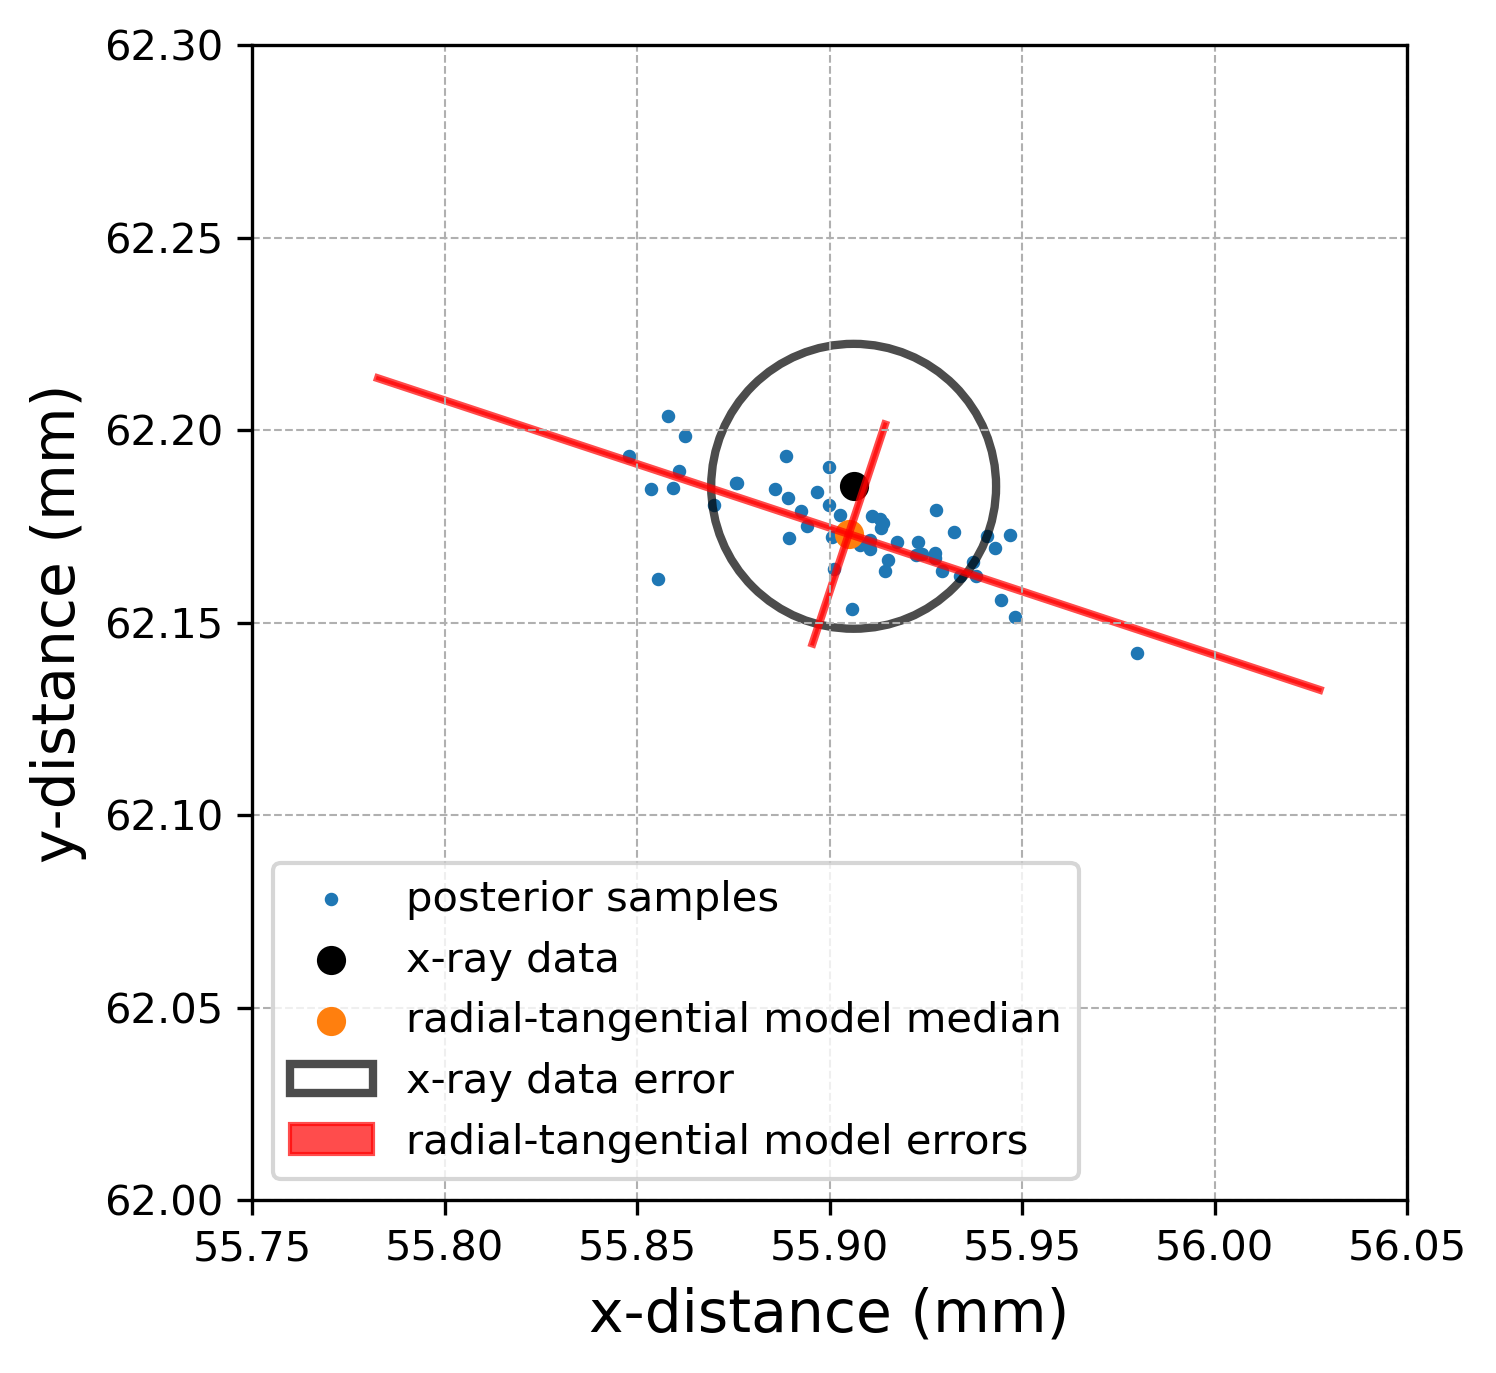

In [57]:
# plot posterior predictive samples
from matplotlib.transforms import Affine2D
import matplotlib.transforms as transforms

# Find X-ray measurement (with error of 0.037mm)

circle = plt.Circle((X[37], Y[37]), 0.037, fill=False, edgecolor='black', linewidth=2, alpha=0.7, label='x-ray data error')

width = 0.001


# determine the angle of rotation for the radial & tangential errorbars 
rectangler = plt.Rectangle((median_pred[0][37]-width/2, median_pred[1][37] - sigma_r[37]), width=width, height=2*sigma_r[37] ,fill=True, color='red', linewidth=1, alpha=0.7,) 
rectanglet = plt.Rectangle((median_pred[0][37]-sigma_t[37], median_pred[1][37] -width/2), width=2*sigma_t[37], height=width ,fill=True, color='red', linewidth=1, alpha=0.7,label="radial-tangential model errors")



# Create the plot
fig,axes = plt.subplots(1,1, figsize=(5,5))
fig.set_dpi(300)

t = transforms.Affine2D().rotate_deg_around(median_pred[0][37], median_pred[1][37], np.arctan2(median_pred[1][37]-135, median_pred[0][37]-80) * 180/np.pi - 90)

rectangler.set_transform(t + axes.transData)
rectanglet.set_transform(t + axes.transData)

axes.scatter(hole38[::2], hole38[1::2], s=5,label='posterior samples')
axes.scatter(X[37],Y[37], color='black',label='x-ray data')
axes.scatter(median_pred[0][37], median_pred[1][37],label='radial-tangential model median')
axes.add_artist(circle)
axes.add_patch(rectangler)
axes.add_patch(rectanglet)

# Customize labels and title
axes.set_xlabel('x-distance (mm)', fontsize=14)

axes.set_ylabel('y-distance (mm)', fontsize=14)


# Add a grid and adjust appearance
axes.grid(True, which='both', linestyle='--', linewidth=0.5)

axes.set_xlim(55.75,56.05)
axes.set_ylim(62,62.3)
# Equal aspect ratio ensures that the rectangle doesn't get distorted
axes.set_aspect('equal')

# Show the plot
plt.legend()

plt.show()



In [58]:
# compute credible intervals 

medians = []
plus_minus = []

for i in range(101):
    for param, values in samples_aligned.items():
            medians.append(np.median(values))
            lower = ((100 - i) / 2)
            upper = 100 - lower

            plus_minus.append(np.percentile(values, [lower, upper]))

In [59]:
# copy data over from isotropic model for comparison
plus_minus[0::28]

plus_minus_isotropic = [[np.float64(355.59107971191406), np.float64(355.59107971191406)],
 [np.float64(355.53269973754885), np.float64(355.65013671875)],
 [np.float64(355.497551574707), np.float64(355.690260925293)],
 [np.float64(355.44242126464843), np.float64(355.73384979248044)],
 [np.float64(355.38993896484374), np.float64(355.78662841796876)],
 [np.float64(355.35356216430665), np.float64(355.83761138916014)],
 [np.float64(355.2971713256836), np.float64(355.8858624267578)],
 [np.float64(355.2543338012695), np.float64(355.9228125)],
 [np.float64(355.21275024414064), np.float64(355.96840026855466)],
 [np.float64(355.1659875488281), np.float64(356.0039451599121)],
 [np.float64(355.12593841552734), np.float64(356.04237060546876)],
 [np.float64(355.0869343566894), np.float64(356.090094909668)],
 [np.float64(355.0379919433594), np.float64(356.1579321289062)],
 [np.float64(354.9922576904297), np.float64(356.20349273681643)],
 [np.float64(354.93356750488283), np.float64(356.23927642822264)],
 [np.float64(354.8900947570801), np.float64(356.2938972473145)],
 [np.float64(354.83544372558595), np.float64(356.34846069335936)],
 [np.float64(354.77421829223636), np.float64(356.40054992675783)],
 [np.float64(354.7260690307617), np.float64(356.46425659179687)],
 [np.float64(354.68311630249025), np.float64(356.5085908508301)],
 [np.float64(354.6349304199219), np.float64(356.5514709472656)],
 [np.float64(354.5754669189453), np.float64(356.5987747192383)],
 [np.float64(354.52464782714844), np.float64(356.6347937011719)],
 [np.float64(354.4823068237305), np.float64(356.6783692932129)],
 [np.float64(354.42887939453124), np.float64(356.72972290039064)],
 [np.float64(354.3909721374512), np.float64(356.785343170166)],
 [np.float64(354.3500708007812), np.float64(356.8310513305664)],
 [np.float64(354.3004054260254), np.float64(356.87888534545897)],
 [np.float64(354.25385620117186), np.float64(356.93851684570313)],
 [np.float64(354.2026817321777), np.float64(356.98875122070314)],
 [np.float64(354.16617279052736), np.float64(357.0387252807617)],
 [np.float64(354.1236392211914), np.float64(357.10586029052735)],
 [np.float64(354.07680053710936), np.float64(357.15391662597654)],
 [np.float64(354.01792343139647), np.float64(357.20752243041994)],
 [np.float64(353.9671331787109), np.float64(357.24804626464845)],
 [np.float64(353.91235580444334), np.float64(357.29254989624025)],
 [np.float64(353.8643420410156), np.float64(357.3526342773437)],
 [np.float64(353.81033996582033), np.float64(357.4111752319336)],
 [np.float64(353.76538940429685), np.float64(357.48060516357424)],
 [np.float64(353.70336975097655), np.float64(357.5390412902832)],
 [np.float64(353.6542999267578), np.float64(357.6210906982422)],
 [np.float64(353.607293548584), np.float64(357.67977752685545)],
 [np.float64(353.5430584716797), np.float64(357.7190594482422)],
 [np.float64(353.502855682373), np.float64(357.7737728881836)],
 [np.float64(353.4496875), np.float64(357.837578125)],
 [np.float64(353.39552154541013), np.float64(357.8738952636719)],
 [np.float64(353.3563470458984), np.float64(357.92136444091796)],
 [np.float64(353.28471084594725), np.float64(357.96201065063474)],
 [np.float64(353.2288024902344), np.float64(358.0062371826172)],
 [np.float64(353.17547424316405), np.float64(358.0486183166504)],
 [np.float64(353.1138916015625), np.float64(358.1081848144531)],
 [np.float64(353.0659341430664), np.float64(358.1699836730957)],
 [np.float64(352.9971142578125), np.float64(358.2237927246094)],
 [np.float64(352.9352040100098), np.float64(358.29321975708007)],
 [np.float64(352.8718411254883), np.float64(358.38980895996093)],
 [np.float64(352.79892883300784), np.float64(358.44781188964845)],
 [np.float64(352.7287805175781), np.float64(358.51606018066406)],
 [np.float64(352.663950958252), np.float64(358.58728805541995)],
 [np.float64(352.60457427978514), np.float64(358.64231567382814)],
 [np.float64(352.5443647766113), np.float64(358.70877670288087)],
 [np.float64(352.49571533203124), np.float64(358.7595642089844)],
 [np.float64(352.4339793395996), np.float64(358.8206317138672)],
 [np.float64(352.3491390991211), np.float64(358.90134368896486)],
 [np.float64(352.2745709228516), np.float64(358.9715802001953)],
 [np.float64(352.2057275390625), np.float64(359.0583386230469)],
 [np.float64(352.1503791809082), np.float64(359.1289192199707)],
 [np.float64(352.0568161010742), np.float64(359.1940997314453)],
 [np.float64(351.9922505187988), np.float64(359.27763656616213)],
 [np.float64(351.9050402832031), np.float64(359.34351928710936)],
 [np.float64(351.8315640258789), np.float64(359.4187924194336)],
 [np.float64(351.7606948852539), np.float64(359.5271591186523)],
 [np.float64(351.6912660217285), np.float64(359.6174772644043)],
 [np.float64(351.6000738525391), np.float64(359.6862823486328)],
 [np.float64(351.49970092773435), np.float64(359.76567855834963)],
 [np.float64(351.40964660644534), np.float64(359.85002502441404)],
 [np.float64(351.32691955566406), np.float64(359.96156311035156)],
 [np.float64(351.2515808105469), np.float64(360.0476928710938)],
 [np.float64(351.17171966552735), np.float64(360.1324612426758)],
 [np.float64(351.0813702392578), np.float64(360.2314205932617)],
 [np.float64(350.9709617614746), np.float64(360.33061279296874)],
 [np.float64(350.86529846191405), np.float64(360.4166748046875)],
 [np.float64(350.7692462158203), np.float64(360.5346127319336)],
 [np.float64(350.6783428955078), np.float64(360.62996551513675)],
 [np.float64(350.52642074584963), np.float64(360.7744435119629)],
 [np.float64(350.4216296386719), np.float64(360.8823974609375)],
 [np.float64(350.2852272033691), np.float64(361.0318092346191)],
 [np.float64(350.1396325683594), np.float64(361.1803018188477)],
 [np.float64(350.02148544311524), np.float64(361.3106282043457)],
 [np.float64(349.86304138183596), np.float64(361.47580871582034)],
 [np.float64(349.74156768798827), np.float64(361.6748139953613)],
 [np.float64(349.58324127197267), np.float64(361.87093963623045)],
 [np.float64(349.4724247741699), np.float64(362.089892578125)],
 [np.float64(349.2593310546875), np.float64(362.333095703125)],
 [np.float64(349.05825912475586), np.float64(362.62383544921875)],
 [np.float64(348.8784576416016), np.float64(362.88191772460937)],
 [np.float64(348.59046783447263), np.float64(363.23010177612304)],
 [np.float64(348.2688214111328), np.float64(363.66848632812497)],
 [np.float64(347.79850341796873), np.float64(364.09408416748045)],
 [np.float64(347.2693817138672), np.float64(364.6967022705078)],
 [np.float64(346.41395263671876), np.float64(365.6627841186523)],
 [np.float64(342.6399230957031), np.float64(368.1316223144531)]]

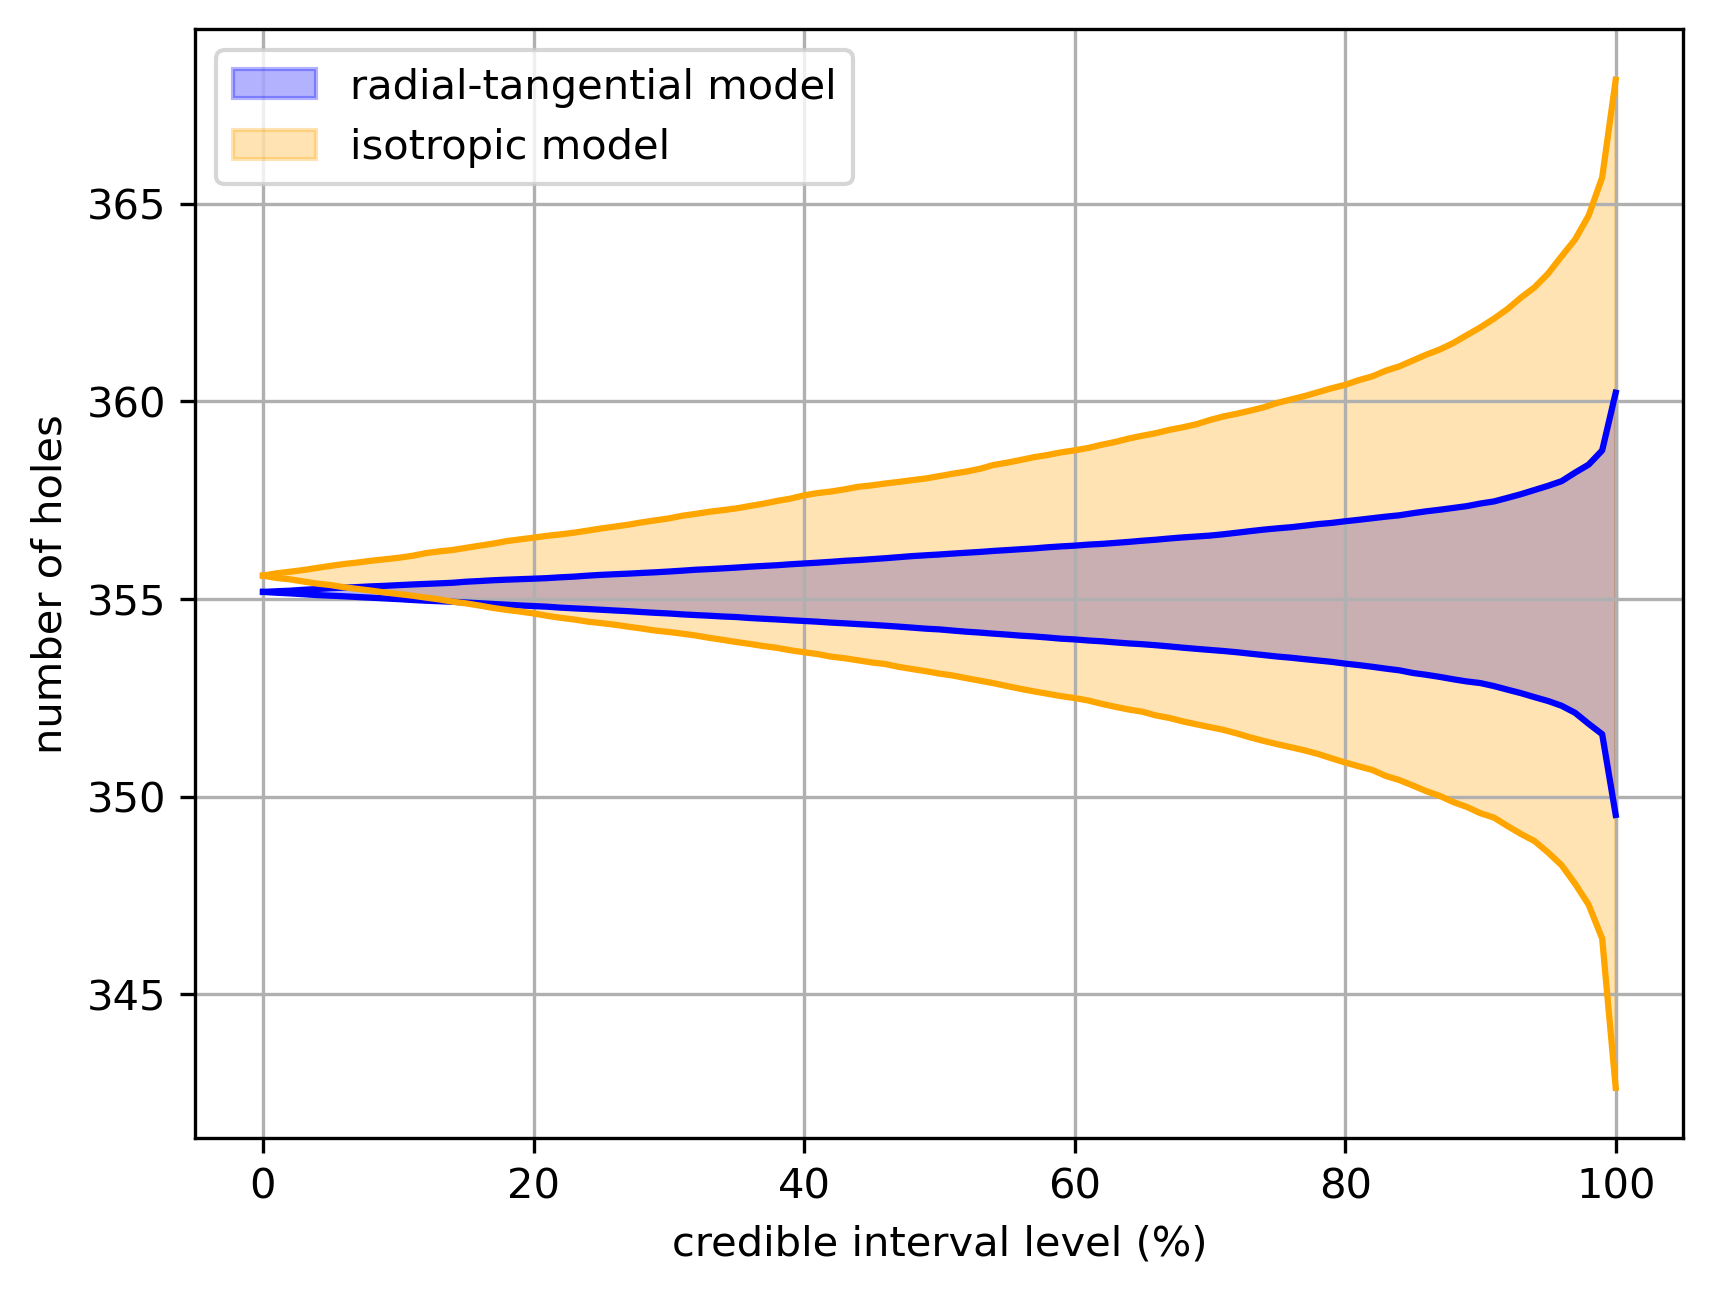

In [60]:
# shade credible intervals for both models

plt.plot(plus_minus[0::28], color='blue')
plt.plot(plus_minus_isotropic, color='orange')

x = np.linspace(0,100,101)

y1 = np.array([item[0] for item in plus_minus[0::28]])
y2 = np.array([item[1] for item in plus_minus[0::28]])

y3 = np.array([item[0] for item in plus_minus_isotropic])
y4 = np.array([item[1] for item in plus_minus_isotropic])

#  blue line upper

plt.fill_between(x, y1,y2, color='blue', alpha=0.3, label='radial-tangential model')  # Upper region
plt.fill_between(x, y3, y4, color='orange', alpha=0.3,label='isotropic model')  # Lower region

plt.xlabel('credible interval level (%)')
plt.ylabel('number of holes')

plt.grid()
plt.legend()

plt.gcf().set_dpi(300)
plt.show()

In [61]:
# Gaussian fit to radial-tangential model

def gauss(N, N_bar, sigma_N):

    return 1/((2*np.pi)**(1/2)*sigma_N) * np.exp(- (N - N_bar)**2 / (2*sigma_N**2))

# search over days 340 - 370
N = np.linspace(342,368,100)

# isotropic model

N_bar_iso = 355.65 
sigma_N_iso = 3.73 

# radial-tangential model

N_bar_ali = 355.17
sigma_N_ali = 1.40

isotropic = gauss(N,N_bar_iso,sigma_N_iso)
aligned = gauss(N,N_bar_ali,sigma_N_ali)

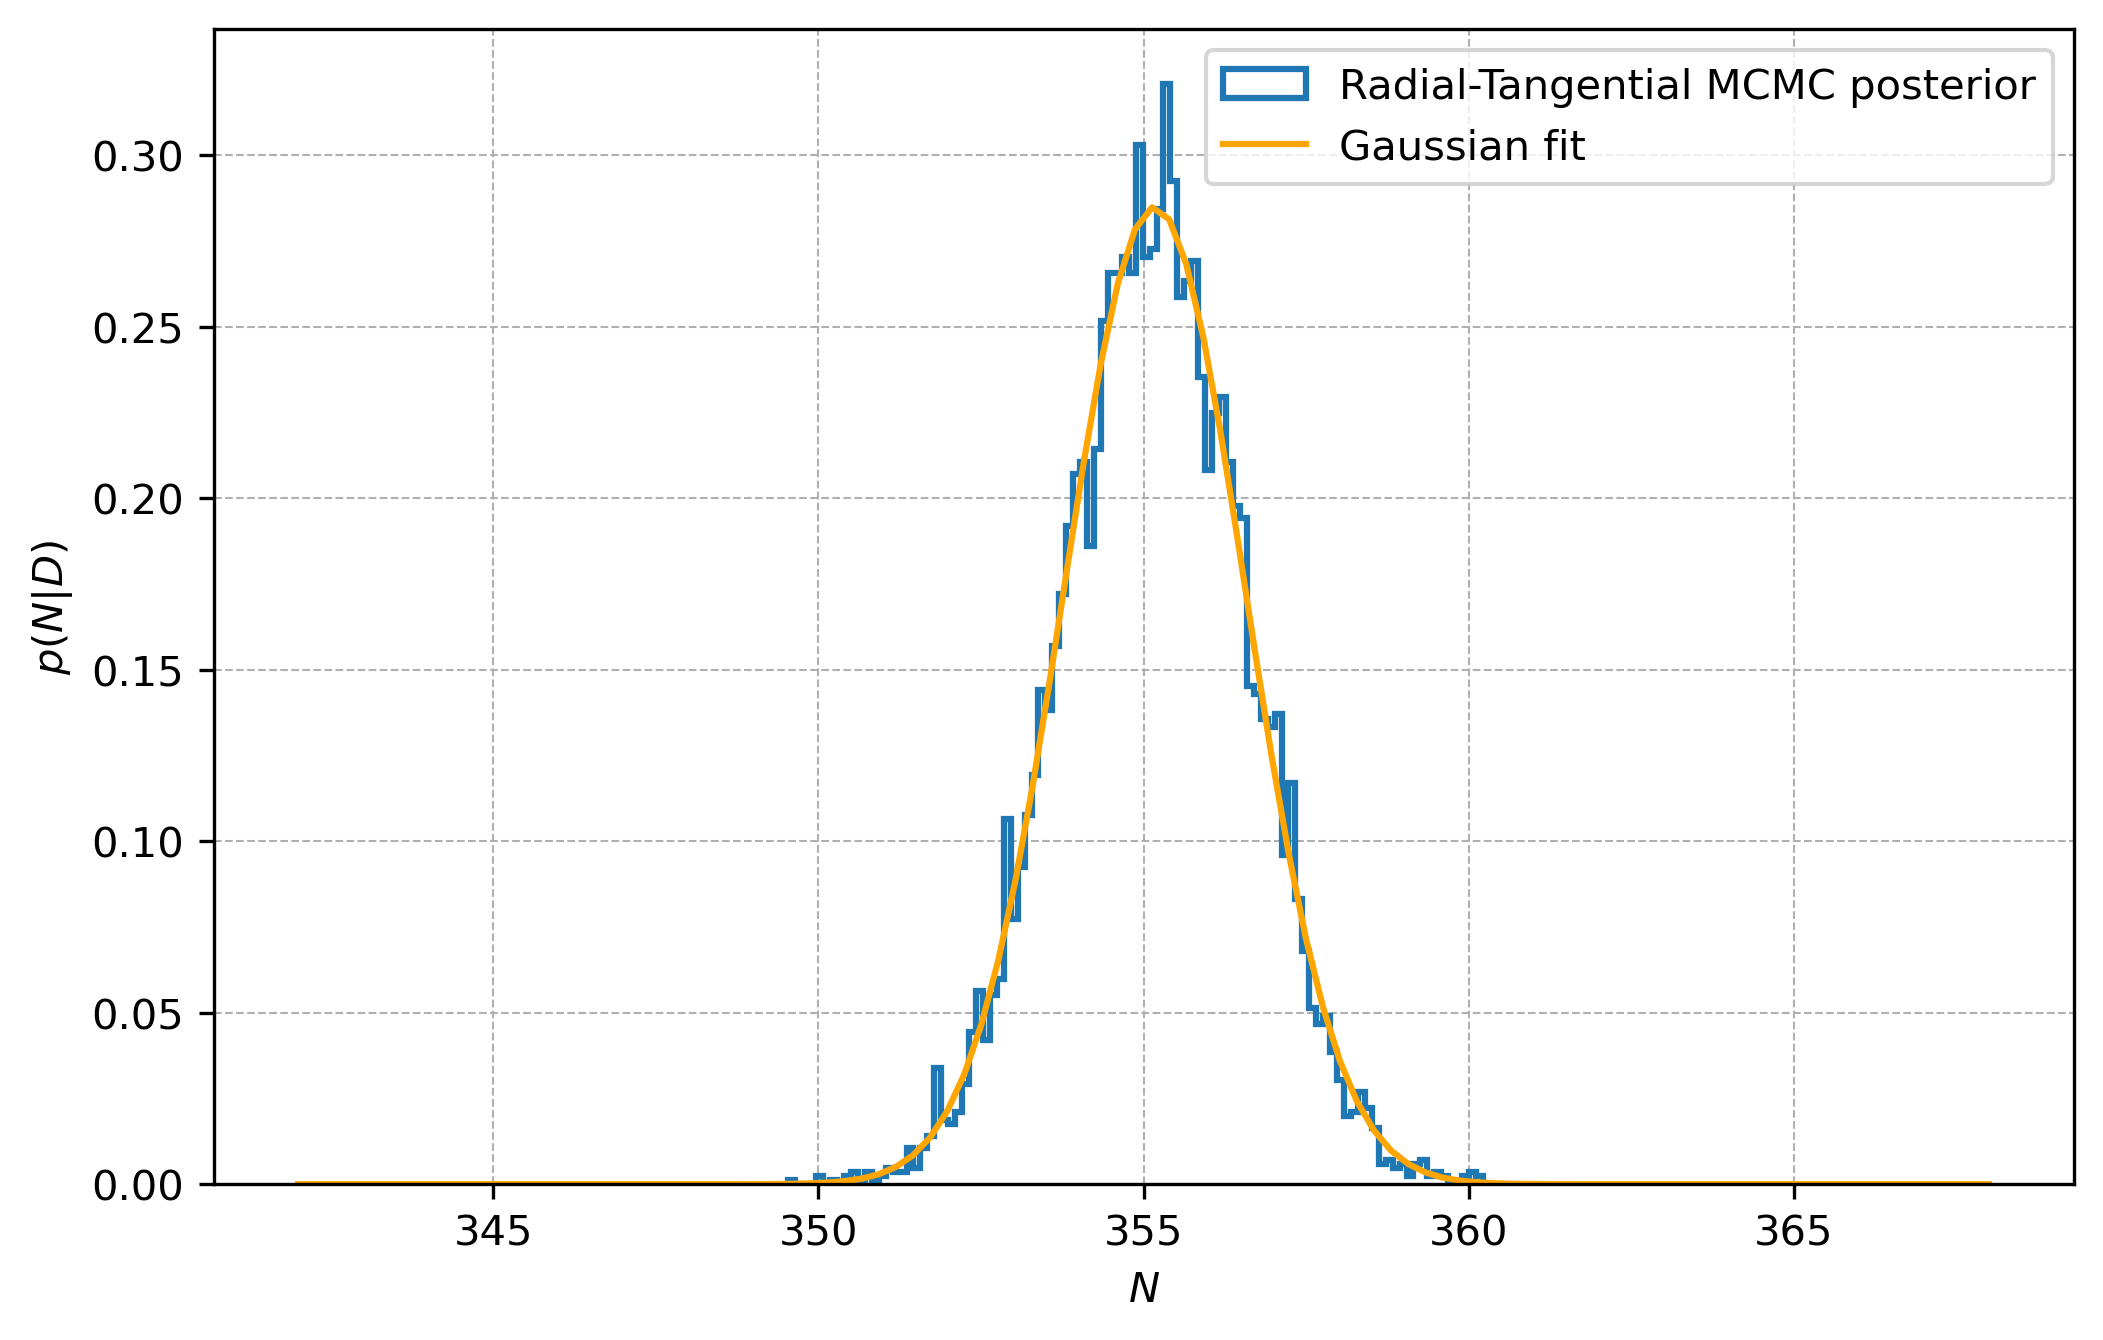

In [62]:
# fit gaussian to mcmc samples of N

posterior_N = mcmc_aligned.get_samples()['N']


fig,ax = plt.subplots(figsize=(8,5))
fig.set_dpi(300)

ax.hist(posterior_N, bins=100, density=True, histtype='step',linewidth=1.5, label='Radial-Tangential MCMC posterior')
ax.plot(N, aligned, color='orange', label='Gaussian fit')

# Add a grid and adjust appearance
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

ax.set_xlabel('$N$')
ax.set_ylabel("$p(N | D)$")

plt.legend()
plt.show()
